In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATTERY_PARTS = [
    '281700','282200','392020','392051','392119','392310', 
    '420212','721240','722230','722699','730120','730690', 
    '732619','732620','740822','740919','740921','741011', 
    '741220','741533','750522','750610','750620','760612', 
    '760719','790700','810590','831110','831120','831190', 
    '850110','850120','850590','850640','850660','850730', 
    '850780','853223','853340','854190','854370','854519', 
    '854720','860900','391910','391990','392069','731822', 
    '854449','391732','280430','290123','292390','281122', 
    '390230','853223','854720','760410','740990','853223', 
    '854720','760410','740990','282300','284210','740811', 
    '853630','382499','761699','830249','854411','848049', 
    '850790','732690','280440','854290','731816','830230', 
    '392099','401699','730711','741999','850680','853222', 
    '390210','382490','854442','282110','853890','853610', 
    '850450','732599','392690','730890','731100','853641'
]

BATTERY = '850760'

# Get Top Suppliers of Battery

In [3]:
index = pd.read_csv("s3://supply-web-data-storage/CSV/index_hs6.csv")

In [4]:
# Check for missing values
index[index['hs6'] == BATTERY].isna().sum()

supplier_t      0
supplier_id     0
buyer_t         1
buyer_id        1
hs6             0
st              0
et              0
bill_count      0
quantity_sum    0
weight_sum      0
amount_sum      0
dtype: int64

In [5]:
def generate_battery_suppliers(index, method_name=None, count=100, df_print=False):   
    if method_name is not None:
        top_suppliers_df = index[index['hs6'] == BATTERY].groupby('supplier_t').agg(
                               indicator_value=(method_name, 'sum')
                           ).sort_values(
                               ["indicator_value"], ascending = False
                           )
    else:
        raise ValueError('Must specify a method for defining largest supplier.')
    if df_print: 
        pd.set_option('display.max_rows', count+1)
        print(top_suppliers_df.head(count))
        pd.reset_option("all")
    top_suppliers = top_suppliers_df.head(count).index
    assert len(top_suppliers) == count
    return top_suppliers

In [6]:
battery_suppliers = generate_battery_suppliers(index, method_name="bill_count", df_print=True)
battery_suppliers

                                                    indicator_value
supplier_t                                                         
dell global b.v                                                6060
wistron corporation                                            3845
sevt                                                           2540
hp international sarl                                          2298
yiwu yihuang import export compan                               826
sehc                                                            689
samsung electronics vietnam thai nguyen co.,ltd                 658
cong ty tnhh dien tu samsung hcmc ce complex                    631
verdant crest technology dmcc                                   508
luxshare precision limited                                      437
railhead corporation                                            421
navitasys technology limited                                    415
motorola mobility llc                           

/opt/anaconda3/lib/python3.9/site-packages/pandas/_config/config.py:653: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/pandas/_config/config.py:653: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


Index(['dell global b.v', 'wistron corporation', 'sevt',
       'hp international sarl', 'yiwu yihuang import export compan', 'sehc',
       'samsung electronics vietnam thai nguyen co.,ltd',
       'cong ty tnhh dien tu samsung hcmc ce complex',
       'verdant crest technology dmcc', 'luxshare precision limited',
       'railhead corporation', 'navitasys technology limited',
       'motorola mobility llc',
       'shenzhen coman electronic technology co.,limited',
       'arnold technologies shenzhen ltd',
       'hongkong hui shun import export trading limited', 'no disponible',
       'samsung electronics co., ltd', 'wingtech group hongkong limited',
       'hefei gotion high-tech power energy co ltd',
       'apple south asia pte ltd', 'shenzhen chenshi technology co., ltd',
       'advan export hk trading co',
       'samsung electronics vietnam company limited',
       'tcl technoly electronics hui zhou co., ltd', 'lenovo pc hk limited',
       'apple distribution international'

# BFS on a supplier

In [7]:
def construct_battery_subgraph(suppliers, tiers, early_stop=True, as_nx=False, nx_kwargs=None):
    '''
    Search starts from tier 1 and exhausts after reaching tier 'tiers'. Note that 'suppliers' are tier 1.
    early_stop: Stop when BFS is exhausted despite not reaching 'tiers'. 
                Store the last explored valid tier in 'early_stop_tier', 
                otherwise 'early_stop_tier' is 'tier'
    '''
    assert tiers >= 1
    early_stop_tiers = tiers
    bom_df = index[index['hs6'].isin(BATTERY_PARTS + [BATTERY])].copy()
    bom_df = bom_df.loc[:,['supplier_t','buyer_t','hs6', 'bill_count']]

    # Find upstream suppliers by tier
    new_suppliers = set(suppliers)
    all_suppliers = set(suppliers) 
    all_suppliers_dict = dict.fromkeys(suppliers, 1) # maps supplier to tier 
    for t in range(2, tiers + 1):    
        df = bom_df[bom_df['buyer_t'].isin(new_suppliers)].copy() 
        new_suppliers  = set(df[df.supplier_t.str.len() > 0].supplier_t.unique())
        new_suppliers = new_suppliers - all_suppliers
        if early_stop and len(new_suppliers) == 0:
            early_stop_tiers = t - 1 # denotes last tier of supplier
            break
        all_suppliers = all_suppliers.union(new_suppliers)
        all_suppliers_dict.update(dict.fromkeys(new_suppliers, t))
        
    # start with edges s.t. supplier_t is in 'suppliers' and upwards
    subgraph_df = bom_df[bom_df['supplier_t'].isin(all_suppliers)].copy() 
    assert all(subgraph_df.supplier_t.str.len() > 0)
    assert all(subgraph_df.buyer_t.str.len() > 0)
    subgraph_df["tier"] = None
    if subgraph_df.shape[0] > 0:
        subgraph_df["tier"] = subgraph_df.apply(
            lambda row: all_suppliers_dict[row.supplier_t],
            axis=1
        )
    return subgraph_df.sort_values(['tier', 'buyer_t'], ascending = True), early_stop_tiers

# Analysis

In [8]:
MAX_TIER = 100

## Q1: as tier increases, when does the graph die? (trend: tier vs num_new_row)

In [9]:
# Q1.1: Size of graph (num_node) for each battery supplier (largest to smallest, top 100)
dict_ = {'supplier_t' : [], 'size' : []}
for bat in battery_suppliers:
    battery_subgraph = construct_battery_subgraph([bat], MAX_TIER)
    assert(battery_subgraph[1] < MAX_TIER)
    
    dict_['supplier_t'].append(bat)
    dict_['size'].append(len(battery_subgraph[0]))
df = pd.DataFrame(dict_)
display(df)

,supplier_t,size
0,dell global b.v,12
1,wistron corporation,70
2,sevt,3170
3,hp international sarl,39
4,yiwu yihuang import export compan,2
...,...,...
95,asus global pte.ltd,1
96,j-run trade limited,3
97,hong kong lishengyuan electronic te,1
98,samsung gulf electronics fze,3173


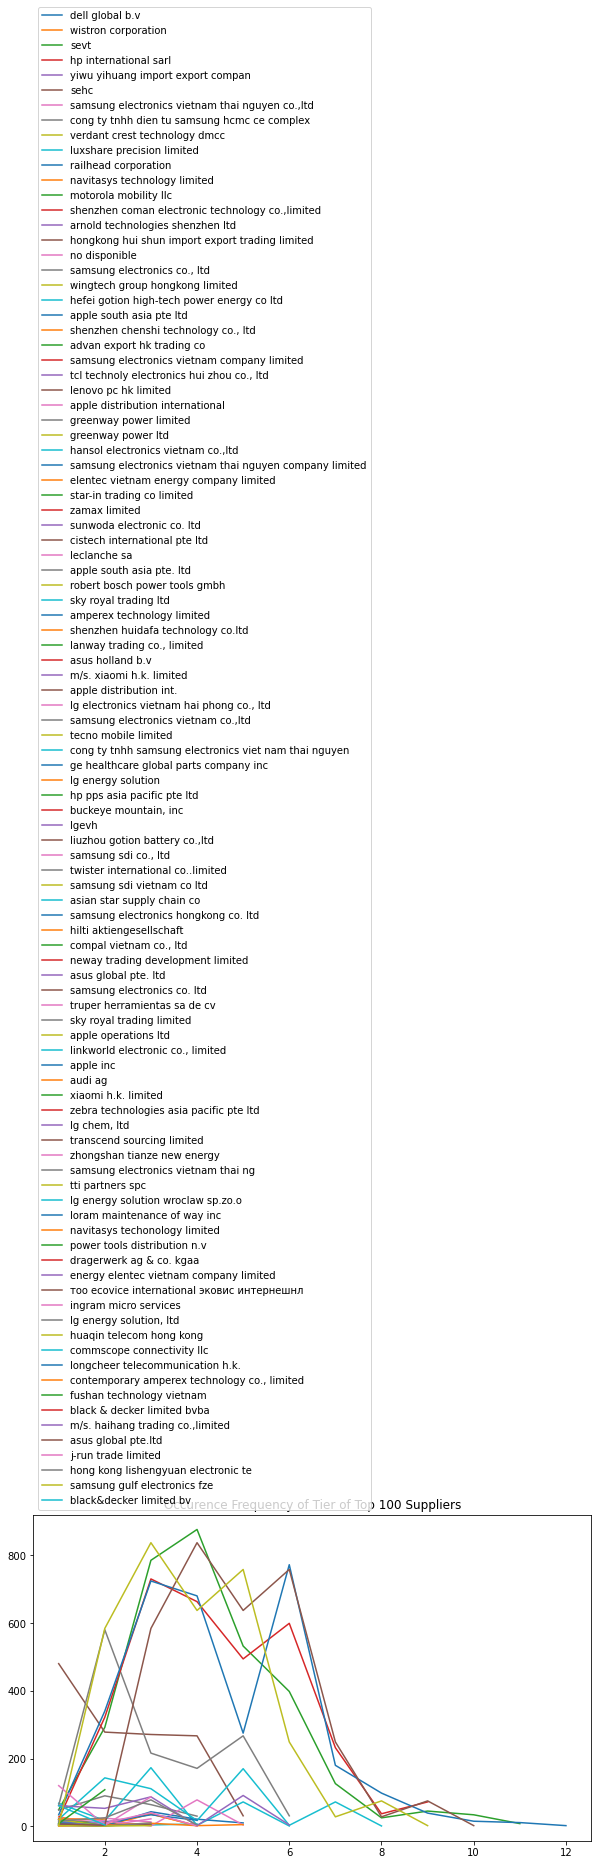

In [10]:
# Q1.2: Where's a supplier at in the supply chain? 
# A1.2: Plot for Top 100: x-axis is 'tier', y-axis is count of occurence
PLOT_CNT = 100
plt.figure(figsize=(10,6))
for bat in battery_suppliers[:PLOT_CNT]:
    battery_subgraph = construct_battery_subgraph([bat], MAX_TIER)
    assert(battery_subgraph[1] < MAX_TIER)
    tier_df = battery_subgraph[0].groupby(['tier'])['tier'].count()
    
    x = list(tier_df.index)
    y = list(tier_df.values)
    
    # check tier
    plt.plot(x, y, label = bat)

plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=1)
plt.title("Occurence Frequency of Tier of Top " + str(PLOT_CNT) + " Suppliers")
plt.show()

## Q2: 'hs6' vs tier as tree depth mean across top suppliers. If BOM correct, we expect the empirical plot to be consistent

In [11]:
construct_battery_subgraph(['dell global b.v'], MAX_TIER)[0]['tier'].values[0] + 1

2

In [29]:
# Construct dicts to record hs_6 code and tier info (mean, std, sum)
from collections import defaultdict

hs6_dict = defaultdict(list) # hs_6 -> tier mean, std, sum

for bat in battery_suppliers:
    battery_subgraph = construct_battery_subgraph([bat], MAX_TIER)
    assert(battery_subgraph[1] < MAX_TIER)
    for _, row in battery_subgraph[0].iterrows():
        hs6_dict[row['hs6']].append(row['tier'])

import statistics
for hs6 in hs6_dict:
    values = hs6_dict[hs6]
    mean = statistics.mean(values)
    std = statistics.stdev(values) if len(values) > 1 else -1 # If stdev not applicable, use -1
    summ = sum(values)
    hs6_dict[hs6] = [mean, std, summ]

In [39]:
df = pd.DataFrame.from_dict(hs6_dict, orient='index', columns=['tier_mean','tier_std','tier_sum'])
# pd.set_option('display.max_rows', 100)
df = df.sort_values(['tier_mean'], ascending = False)
display(df)
pd.reset_option("all")

,tier_mean,tier_std,tier_sum
722699,5.636364,1.813848,124
730711,5.588235,2.670647,95
850790,5.573529,2.451416,379
750610,5.437500,2.046831,174
854290,5.402439,1.942760,443
...,...,...,...
860900,1.000000,-1.000000,1
392051,1.000000,0.000000,2
282110,1.000000,0.000000,2
284210,1.000000,-1.000000,1


/opt/anaconda3/lib/python3.9/site-packages/pandas/_config/config.py:653: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/pandas/_config/config.py:653: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


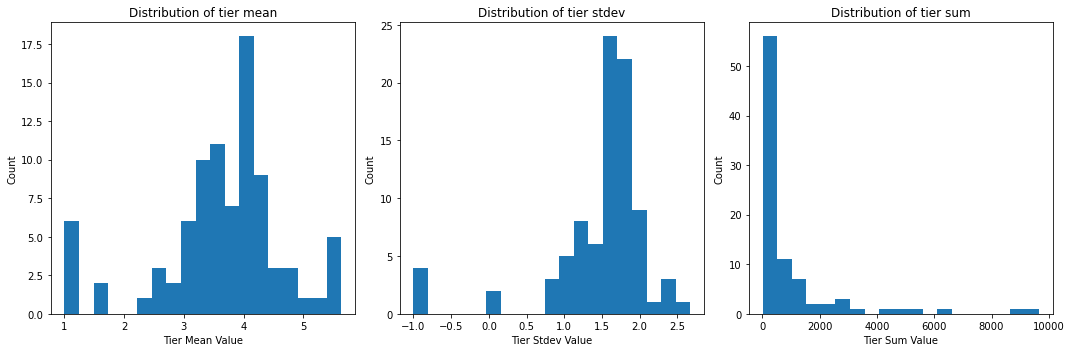

In [55]:
# Sanity check: info of BATTERY = 850760 row
# Sanity check: the ordering of index (hs6 code) should resemble BOM tree, not necessarily numerically equally-spaced
# Plot of distribution of mean, sum, std
plt.subplots(figsize=(15, 5))

num_bins = round((max(df['tier_mean']) - min(df['tier_mean'])) * 4)

plt.subplot(1, 3, 1)
plt.hist(df['tier_mean'], bins=num_bins)
plt.title('Distribution of tier mean')
plt.xlabel('Tier Mean Value')
plt.ylabel('Count')
 
plt.subplot(1, 3, 2)
plt.hist(df['tier_std'], bins=num_bins)
plt.title('Distribution of tier stdev')
plt.xlabel('Tier Stdev Value')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(df['tier_sum'], bins=num_bins)
plt.title('Distribution of tier sum')
plt.xlabel('Tier Sum Value')
plt.ylabel('Count')
 
# space between the plots
plt.tight_layout()

# show plot
plt.show()

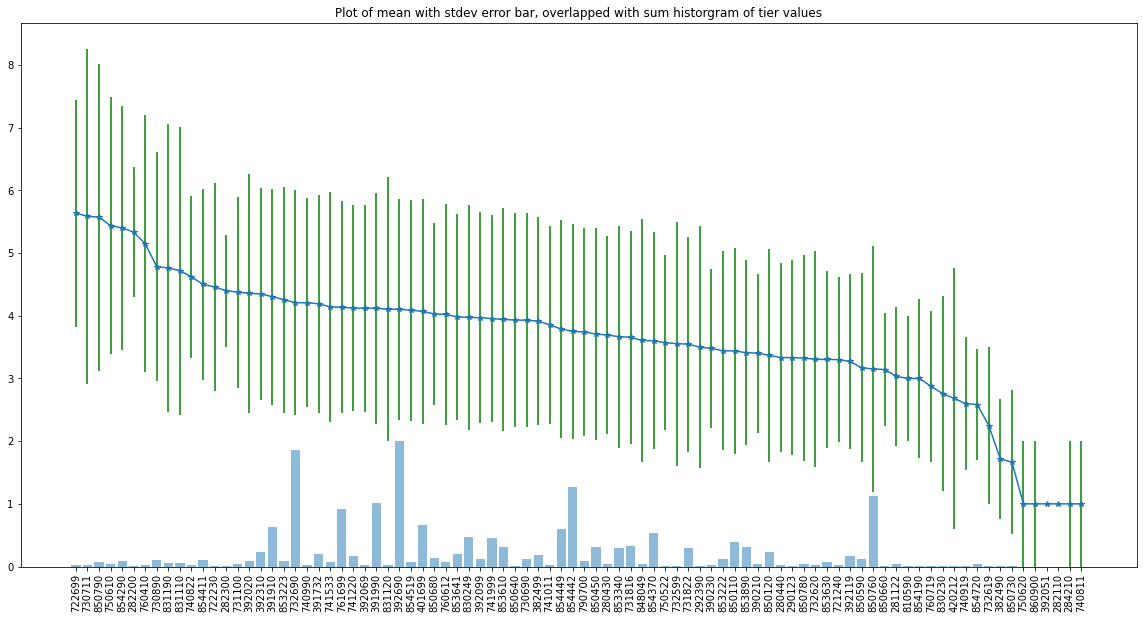

In [64]:
# Plot of mean, variance, overlapped with sum histogram
x = np.array(df.index)
y = np.array(df['tier_mean'].values)
e = np.array(df['tier_std'].values)
s = np.array(df['tier_sum'].values)

SUM_SCALE = max(s) / 2

plt.figure(figsize=(20, 10))
plt.errorbar(x, y, e, linestyle='-', marker='*', ecolor='green')
plt.bar(x, s / SUM_SCALE, alpha=0.5, label='sum') # Scaled to show trend, not actual values
plt.xticks(rotation = 90)
plt.title("Plot of mean with stdev error bar, overlapped with scaled sum historgram of tier values")
plt.show()

In [ ]:
# TODO: check for a specific company

## Q3: compare and contrast different suppliers